<a href="https://colab.research.google.com/github/annnyway/QA-for-Russian/blob/master/Baseline_Lorenzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip3 install razdel pytorch_pretrained_bert regex
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from razdel import tokenize
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertForMaskedLM, BertConfig
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def tokenize_text(text):
    """Токенизация"""
    words = [_.text for _ in list(tokenize(text))]
    return words


class QADataset(Dataset):

    def __init__(self, tokenizer: BertTokenizer,
                 paragraph_tokens: list,
                 question_tokens: list,
                 answer_spans: list,
                 word2index: dict,
                 verbose=True,
                 max_seq_len=512,
                pad_token="[PAD]"):

        super().__init__()
        self.tokenizer = tokenizer
        self.word2index = word2index
        self.word2bert_tokens = {word: self.tokenizer.tokenize(word) for word
                                 in tqdm(list(self.word2index.keys())[1:])}
        self.word2bert_indices = {
            word: [self.tokenizer.vocab[bert_token] for bert_token in
                   self.word2bert_tokens[word]] for word in
            self.word2bert_tokens.keys()}

        self.sequence_length = max_seq_len
        self.pad_index = self.word2index[pad_token]

        self.x_data = []
        self.y_data = []
        self.load_x_y(paragraph_tokens, question_tokens, answer_spans)

    def load_x_y(self, paragraphs, questions, spans, verbose=True):
        for par, quest, span in tqdm(zip(paragraphs, questions, spans),
                                     desc="Loading data", disable=not verbose):
            tokens = ["[CLS]"] + par + ["[SEP]"] + quest + ["[SEP]"]
            start, end = span.split(",")
            start, end = int(start), int(end)
            bert_tokens = [self.word2bert_indices[word] for word in tokens]
            bert_span_start = sum(len(x) for x in bert_tokens[:start + 1])
            bert_span_end = sum(len(x) for x in bert_tokens[:end + 1]) # прибавляем 1, т.к. у нас в начале есть еще токен CLS
            span = (bert_span_start, bert_span_end) 
            
            bert_tokens = sum(bert_tokens, [])
            par_tokens = [self.word2bert_indices[word] for word in ["[CLS]"] + par]
            que_tokens = [self.word2bert_indices[word] for word in ["[SEP]"] + quest + ["[SEP]"]]
            if len(bert_tokens) + 3 > 512:
                if bert_span_start <= len(par_tokens)/2: # если спан в первой половине параграфа
                    slice_ = len(bert_tokens) - 512
                    bert_tokens = sum(par_tokens[:-slice_] + que_tokens, [])
                elif bert_span_start > len(par_tokens)/2:
                    slice_ = len(bert_tokens) - 512
                    bert_tokens = sum(par_tokens[slice_:] + que_tokens, [])
                    bert_span_start = bert_span_start - slice_
                    bert_span_end = bert_span_end - slice_
                    span = (bert_span_start, bert_span_end)
                elif bert_span_start > 1024:
                    factor = floor(len(bert_tokens)/512)
                    slice_ = len(bert_tokens) - 512*factor
                    bert_tokens = sum(par_tokens[slice_:] + que_tokens, [])
                    bert_span_start = bert_span_start - slice_
                    bert_span_end = bert_span_end - slice_
      
            self.x_data.append(bert_tokens)
            self.y_data.append(span)

    def padding(self, sequence):
        if len(sequence) > self.sequence_length:
            sequence = sequence[: self.sequence_length]
        elif len(sequence) < self.sequence_length:
            sequence += [self.pad_index for i in
                         range(self.sequence_length - len(sequence))]
        return sequence

    def create_y_matrix(self, span):
        startspan = span[0]
        endspan = span[1]
        ansten = torch.zeros(512).long()
        for i in range(startspan, endspan):
            if i <= 512:
                ansten[i] = 1
            else:
                continue
        return ansten  


    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):

        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        y = self.y_data[idx]
        return x, y


In [0]:
data = pd.read_csv("/content/drive/My Drive/COLABDRIVE/sdsj2017_sberquad_with_spans(minus_30_examples).csv")
data['span_len'] = data.apply(lambda row: int(row.word_answer_span.split(",")[1]) - int(row.word_answer_span.split(",")[0]), axis = 1) 
data['span_avg'] = data.apply(lambda row: (int(row.word_answer_span.split(",")[1])+int(row.word_answer_span.split(",")[0]))/2, axis = 1)
data = data[(data.span_len <= 10) & (data.span_avg <= 150)]
data = data.sample(frac=0.11, random_state=42) 

tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/COLABDRIVE/", do_lower_case=False)

In [54]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [58]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(data, test_size=0.3, random_state=42)
dev, test = train_test_split(temp, test_size=0.5, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
dev = dev.reset_index(drop=True)

par_tokens_train = [i.split() for i in train.paragraph_tokens]
que_tokens_train = [tokenize_text(i) for i in train.question]
answer_spans_train = train.word_answer_span

par_tokens_test = [i.split() for i in test.paragraph_tokens]
que_tokens_test = [tokenize_text(i) for i in test.question]
answer_spans_test = test.word_answer_span

par_tokens_dev = [i.split() for i in dev.paragraph_tokens]
que_tokens_dev = [tokenize_text(i) for i in dev.question]
answer_spans_dev = dev.word_answer_span

word2index = {"[PAD]":0, "[CLS]":1, "[SEP]":2}

for sent in par_tokens_train:
    for token in sent:
        if token not in word2index:
            word2index[token] = len(word2index)

for sent in par_tokens_test:
    for token in sent:
        if token not in word2index:
            word2index[token] = len(word2index)

for sent in par_tokens_dev:
    for token in sent:
        if token not in word2index:
            word2index[token] = len(word2index)
            
for que in que_tokens_train:
    for token in que:
        if token not in word2index:
            word2index[token] = len(word2index)

for que in que_tokens_test:
    for token in que:
        if token not in word2index:
            word2index[token] = len(word2index)

for que in que_tokens_dev:
    for token in que:
        if token not in word2index:
            word2index[token] = len(word2index)


train_data = QADataset(tokenizer=tokenizer,
                   paragraph_tokens=par_tokens_train,
                   question_tokens=que_tokens_train,
                   answer_spans=answer_spans_train,
                   word2index=word2index)

test_data = QADataset(tokenizer=tokenizer,
                   paragraph_tokens=par_tokens_test,
                   question_tokens=que_tokens_test,
                   answer_spans=answer_spans_test,
                   word2index=word2index)

dev_data = QADataset(tokenizer=tokenizer,
                   paragraph_tokens=par_tokens_dev,
                   question_tokens=que_tokens_dev,
                   answer_spans=answer_spans_dev,
                   word2index=word2index)

In [0]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)


class Classifier(torch.nn.Module):
    
#from Softmax we get the probability of word being in the answer, 
#we need as Y for loss a matrix (word positionally encoded) of 0 and 1 with 1 being words in span.
    def __init__(self, 
               hidden_size=3072,  
               linear_out=24,
               batch_first=True):
  
        super(Classifier, self).__init__()
            
        self.output_model_file = "/content/drive/My Drive/COLABDRIVE/pytorch_model.bin"
        self.output_config_file = "/content/drive/My Drive/COLABDRIVE/config.json"
        self.tokenizer = BertTokenizer.from_pretrained("/content/drive/My Drive/COLABDRIVE/", do_lower_case=False)
        self.config = BertConfig.from_json_file(self.output_config_file)
        self.model = BertForMaskedLM(self.config)
        device = ('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.state_dict = torch.load(self.output_model_file, map_location=device)
        self.model.load_state_dict(self.state_dict)

        if torch.cuda.is_available():       
            self.simplelayer = torch.nn.Linear(in_features = hidden_size, out_features = linear_out).cuda()
            self.dropout = torch.nn.Dropout(p=0.3).cuda()
            self.relu = torch.nn.LeakyReLU().cuda()
            self.simplelayer2 = torch.nn.Linear(in_features = linear_out, out_features=1).cuda()
        else:
            self.simplelayer = torch.nn.Linear(in_features = hidden_size, out_features = linear_out)
            self.dropout = torch.nn.Dropout(p=0.3)
            self.relu = torch.nn.LeakyReLU()
            self.simplelayer2 = torch.nn.Linear(in_features = linear_out, out_features=1)
        
    
    def attention_head(self, x):
    
    q = query(x)
    k = key(x)
    v = value(x)
    attention_scores = torch.sqrt(torch.matmul(q, k.T))
    attention_distribution = torch.nn.functional.softmax(attention_scores, dim=1)
    x = torch.matmul(attention_distribution, v)
    return x

    def get_embeddings(self, x_instance):   
        indexed_tokens = x_instance.tolist()
        break_sentence = indexed_tokens.index(102)
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_ids = [0] * (break_sentence+1)
        segments_ids += [1] * (len(indexed_tokens) - break_sentence - 1) 
        segments_tensors = torch.tensor([segments_ids])
        self.model.eval()
        with torch.no_grad():
            encoded_layers, _ = self.model.bert(tokens_tensor,
                                       segments_tensors)
        token_embeddings = torch.stack(encoded_layers, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1, 0, 2)
        token_vecs_cat = []
        for token in token_embeddings:
            cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]),
                                dim=0)
            token_vecs_cat.append(cat_vec)
        token_vecs_cat = torch.stack(token_vecs_cat, dim=0)
        return token_vecs_cat

    
    def embed_data(self, x): 
        entries = [] 
        #data_iterator = tqdm(x, desc='Loading embeddings')    
        for entry in x:
            emb = self.get_embeddings(entry)
            entries.append(emb)
        return torch.stack(entries)

  
    def forward(self, x):    #super(CNN, self).__init__()
        
        h = self.embed_data(x)
        h = self.dropout(h)
        h = self.simplelayer(h)
        h = self.relu(h)
        pred = self.simplelayer2(h)
        
        return pred

In [0]:
train_loader = DataLoader(train_data, batch_size=24, drop_last=True)
test_loader = DataLoader(test_data, batch_size=24, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=24, drop_last=True)

device = ('cuda') if torch.cuda.is_available() else torch.device('cpu')

model1 = Classifier()
model2 = Classifier()
criterion1 = torch.nn.CrossEntropyLoss().to(device)
criterion2 = torch.nn.CrossEntropyLoss().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0005)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0005)

#iteration_losses_start = []
#iteration_losses_end = []
epoch_train_losses = []
epoch_test_losses = []
accuracies = []
f_scores = []

#state = torch.load("/content/drive/My Drive/COLABDRIVE/sberqa_model.pt")
#model.load_state_dict(state['state_dict'])
#optimizer.load_state_dict(state['optimizer'])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




EPOCH NUMBER 1 START


train loss is: 4.011424891258541
test loss is: 3.8718800619244576


EPOCH NUMBER 1 END


train loss is: 3.8476482331752777
test loss is: 3.6782864928245544
test loss is: 3.6782864928245544


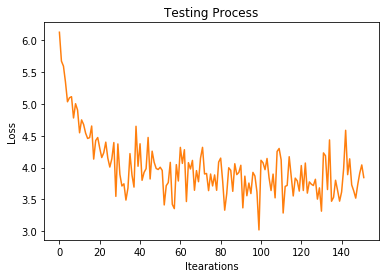

In [82]:
test_loss_result = [0, 0]
train_loss_result = [0, 0]
epochs = 0
while test_loss_result[-2] - test_loss_result[-1] > 0.005 or epochs < 2:

    epochs += 1
    train_2 = []
    test_2 = []

    try:
            
        train_losses_start = []
        train_losses_end = []
        test_losses_start = []
        test_losses_end = []
        spanlist_start = []
        spanlist_end = []
        predictedlist_start = []
        predictedlist_end = []
    
        progress_bar1 = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(epochs))
        progress_bar2 = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(epochs))

        for x, y in train_loader:
            
            #startclass
            optimizer1.zero_grad()
            pred1 = model1.forward(x.to(device))
            loss1 = criterion1(pred1.to(device), y[0].unsqueeze(1).long().to(device))
            loss1.backward()
            optimizer1.step()
            metric1 = np.mean(train_losses_start[-500:])
            #iteration_losses_start.append(loss1.item())
            train_losses_start.append(loss1.item())
            progress_bar1.set_postfix(loss=metric1)
            progress_bar1.update(x.shape[0])

            #endclass
            optimizer2.zero_grad()
            pred2 = model2.forward(x.to(device))
            loss2 = criterion2(pred2.to(device), y[1].unsqueeze(1).long().to(device))
            loss2.backward()
            optimizer2.step()
            metric2 = np.mean(train_losses_end[-500:])
            #iteration_losses_end.append(loss2.item())
            train_losses_end.append(loss2.item())
            progress_bar2.set_postfix(loss=metric2)
            progress_bar2.update(x.shape[0])
        
        progress_bar1.close()
        progress_bar2.close()
        train_2.append(np.mean(train_losses_start))
        train_2.append(np.mean(train_losses_end))

        with torch.no_grad():
            progress_bar1 = tqdm(total=len(dev_loader.dataset), desc='Test')
            progress_bar2 = tqdm(total=len(dev_loader.dataset), desc='Test')
            for datatest in dev_loader:

                #startdev
                texts, span = datatest
                predt1 = model1.forward(texts.to(device))
                test_losses_start.append(float(torch.nn.functional.cross_entropy(predt1.to(device), span[0].unsqueeze(1).long().to(device)).cpu().numpy())) # sum up batch loss
                spanlist_start.append(torch.argmax(predt1, dim=1).tolist())
                predictedlist_start.append(span[0].unsqueeze(1).tolist())
                progress_bar1.set_postfix(loss=np.mean(test_losses_start))
                progress_bar1.update(texts.shape[0])

                #enddev
                predt2 = model2.forward(texts.to(device))
                test_losses_end.append(float(torch.nn.functional.cross_entropy(predt2.to(device), span[1].unsqueeze(1).long().to(device)).cpu().numpy())) # sum up batch loss
                spanlist_end.append(torch.argmax(predt2, dim=1).tolist())
                predictedlist_end.append(span[1].unsqueeze(1).tolist())
                progress_bar2.set_postfix(loss=np.mean(test_losses_end))
                progress_bar2.update(texts.shape[0])
        
        progress_bar1.close()
        progress_bar2.close()
        test_2.append(np.mean(test_losses_start))
        test_2.append(np.mean(test_losses_end))
        test_loss_result.append(np.mean(test_2))
        train_loss_result.append(np.mean(train_2))
    
        print("\n" + "\n" + "EPOCH NUMBER " + str(epochs) + " START" "\n" + "\n")
        print("train loss is: " + str(train_2[-2]))
        print("test loss is: " + str(test_2[-2]))
        print("\n" + "\n" + "EPOCH NUMBER " + str(epochs) + " END" "\n" + "\n")
        print("train loss is: " + str(train_2[-1]))
        print("test loss is: " + str(test_2[-1]))

    except KeyboardInterrupt:

        progress_bar.close()
    
        break
    
    #state = {
    #'epoch': n_epoch,
    #'state_dict': model1.state_dict,
    #'optimizer': optimizer.state_dict,
    #'loss': epoch_train_losses
    #}
    #torch.save(state, "/content/drive/My Drive/COLABDRIVE/sberqa_model.pt")

In [0]:
spanlist = []
predictedlist = []
test_loss = []
with torch.no_grad():
      progress_bar = tqdm(total=len(test_loader.dataset), desc='Test')

      for datatest in test_loader:
          texts, span = datatest
          pred = model1.forward(x.to(device))
          test_loss.append(float(torch.nn.functional.cross_entropy(pred.to(device), span[0].unsqueeze(1).long().to(device)).cpu().numpy())) # sum up batch loss
          #spanlist.append()
          #predictedlist.append()
          progress_bar.set_postfix(loss=np.mean(test_loss))
          progress_bar.update(texts.shape[0])
      progress_bar.close()

In [0]:
#torch.save(model, "/content/drive/My Drive/COLABDRIVE/sber_model2.pt")

In [0]:
#spanlist[0][0][0]
#for i in zip(range(0, len(pred[2].squeeze().tolist())),pred[2].squeeze().tolist()):
#    print(i)


In [73]:
train_losses

[3.7533514499664307,
 3.9576528072357178,
 3.9209938049316406,
 3.386037826538086,
 3.129312753677368,
 3.795919179916382,
 3.726536989212036,
 3.1748154163360596,
 3.5939958095550537,
 3.7223093509674072,
 3.5195066928863525,
 4.081770896911621,
 3.365565061569214,
 3.915959119796753,
 3.7463061809539795,
 3.6888656616210938,
 3.7245032787323,
 3.493180990219116,
 4.122745990753174,
 3.7220449447631836,
 3.459670305252075,
 3.432318687438965,
 3.6813056468963623,
 3.8364057540893555,
 3.6087305545806885,
 3.693652391433716,
 3.9022810459136963,
 4.240566253662109,
 3.258962631225586,
 4.126262187957764,
 3.4779489040374756,
 3.427872896194458,
 3.565488815307617,
 3.325183629989624,
 3.1877822875976562,
 3.7225911617279053,
 3.414555788040161,
 3.56701397895813,
 4.314891338348389,
 3.5922842025756836,
 4.290772914886475,
 3.5799102783203125,
 3.5706043243408203,
 3.5523195266723633,
 4.166256904602051,
 3.9088761806488037,
 4.121034145355225,
 3.878890037536621,
 3.7558414936065674,


In [92]:
loss1.add(loss2)

tensor(8.5880, grad_fn=<AddBackward0>)